In [1]:
import os
import time
import numpy as np
import pandas as pd
import threading as th

from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('train.csv',engine='c',memory_map=True)

In [6]:
pickupDatetime  = pd.to_datetime(df.pickup_datetime)
dropoffDatetime = pd.to_datetime(df.dropoff_datetime)

dfDrop = df.drop(['id','pickup_datetime','dropoff_datetime'],axis=1)

# On reccréé des colonnes de pickup en séparant les informations de la date
dfDrop['pickupHour'] = pickupDatetime.dt.hour
dfDrop['pickupDayOfWeek'] = pickupDatetime.dt.dayofweek
dfDrop['pickupWeekOfYear'] = pickupDatetime.dt.weekofyear
dfDrop['pickupDayOfYear'] = pickupDatetime.dt.dayofyear
dfDrop['pickupMonth'] = pickupDatetime.dt.month

# Pareil pour le dropoff
dfDrop['dropoffHour'] = dropoffDatetime.dt.hour
dfDrop['dropoffDayOfWeek'] = dropoffDatetime.dt.dayofweek
dfDrop['dropoffWeekOfYear'] = dropoffDatetime.dt.weekofyear
dfDrop['dropoffDayOfYear'] = dropoffDatetime.dt.dayofyear
dfDrop['dropoffMonth'] = dropoffDatetime.dt.month

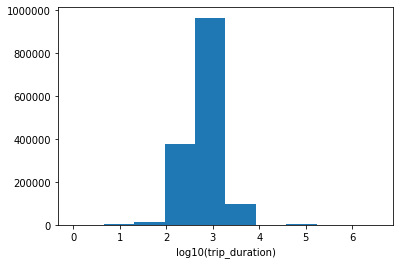

In [7]:
plt.hist(np.log10(df.trip_duration.values))
plt.xlabel('log10(trip_duration)')
plt.show()

In [8]:
# Avec ce graphique, on voit que la majoritée des valeurs se situent entre 10^2 et 10^(3,5) ~= 3200
# On peut donc supprimer les autres valeurs
dfGoodDurations = dfDrop[(dfDrop.trip_duration >= 100) & (dfDrop.trip_duration < 3200)]
print(dfDrop.shape)
print(dfGoodDurations.shape)

(1458644, 18)
(1420735, 18)


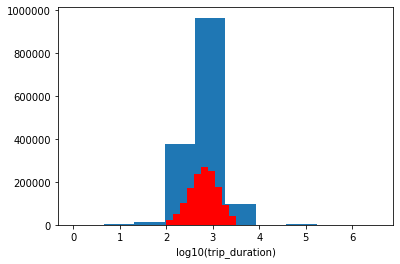

In [9]:
# Beaucoup de valeur ont enlevé
plt.hist(np.log10(df.trip_duration.values))
plt.hist(np.log10(dfGoodDurations.trip_duration.values),color='red')
plt.xlabel('log10(trip_duration)')
plt.show()

In [10]:
# On veut afficher la matrice de corrélation pour voir quelle variables dépendent le plus linéairement des autres. Pour cela on a besoin de transformer les valeurs de la colonne store_and_fwd_flag en chiffre. Pour cela on va utiliser un OHEncoder. Pour l'instant je vais juste les enlever
dfUsable = dfGoodDurations.drop(['store_and_fwd_flag'], axis=1)

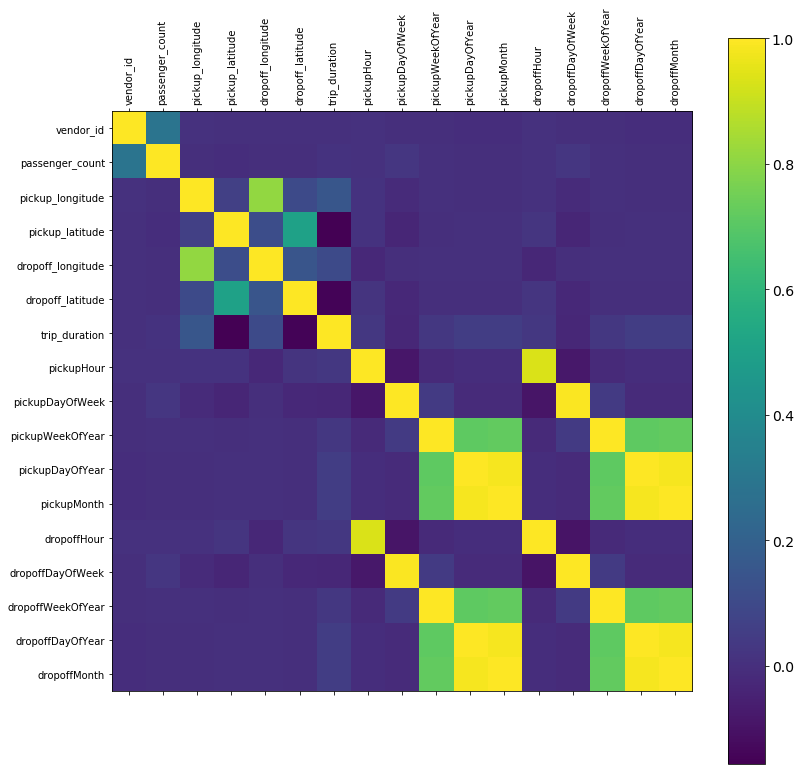

In [11]:
# On affiche la matrice de corélation pour voir quelles valeurs sont +/- corrélée entre elles
f = plt.figure(figsize=(13,13))
plt.matshow(dfUsable.corr(), fignum=f.number)
plt.xticks(range(dfUsable.shape[1]),labels=dfUsable.columns,rotation=90)
plt.yticks(range(dfUsable.shape[1]),dfUsable.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [9]:
dfUsable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1420735 entries, 0 to 1458643
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vendor_id          1420735 non-null  int64  
 1   passenger_count    1420735 non-null  int64  
 2   pickup_longitude   1420735 non-null  float64
 3   pickup_latitude    1420735 non-null  float64
 4   dropoff_longitude  1420735 non-null  float64
 5   dropoff_latitude   1420735 non-null  float64
 6   trip_duration      1420735 non-null  int64  
 7   pickupHour         1420735 non-null  int64  
 8   pickupDayOfWeek    1420735 non-null  int64  
 9   pickupWeekOfYear   1420735 non-null  int64  
 10  pickupDayOfYear    1420735 non-null  int64  
 11  pickupMonth        1420735 non-null  int64  
 12  dropoffHour        1420735 non-null  int64  
 13  dropoffDayOfWeek   1420735 non-null  int64  
 14  dropoffWeekOfYear  1420735 non-null  int64  
 15  dropoffDayOfYear   1420735 non-n

In [12]:
# On voit que trip_duration n'est pas corrélé linéairement avec beaucoup de variables. Il est donc probable que les algorithmes de regression linéaires ne donnent pas de bon résultats. On va essayer de trouver quelles variables sont intéressantes pour l'apprentissage.
print(dfUsable.passenger_count.value_counts())

1    1006618
2     204748
5      76156
3      58474
6      47113
4      27611
0         13
9          1
8          1
Name: passenger_count, dtype: int64


In [13]:
# On voit qu'il y a quelques valeurs pour 0 9 et 8 passagers. Comme on veut prédire des trajets, le but est qu'il y ait des passagers dans les taxi, on peut donc supprimer les lignes avec 0 passager, et 9 et 8, 1 seule entrée est innutile pour l'apprentissage
dfWithoutBadPCount = dfUsable[(dfUsable.passenger_count != 0) & (dfUsable.passenger_count != 9) & (dfUsable.passenger_count != 8)]

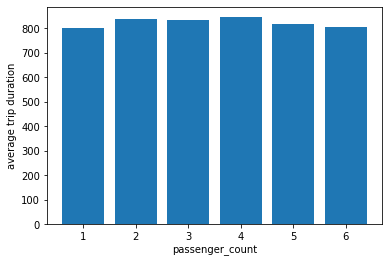

In [14]:
groupByPassengerCount = dfWithoutBadPCount.groupby('passenger_count')[['trip_duration']].mean()
groupByPassengerCount.reset_index(inplace=True)
plt.bar(groupByPassengerCount.passenger_count.values,groupByPassengerCount.trip_duration.values)
plt.xlabel('passenger_count')
plt.ylabel('average trip duration')
plt.show()

In [15]:
# Les valeurs sont assez proches (entre 800 et 840), on peut donc supprimer le champs nombre de passagers qui n'a pas l'ai très intéressant
dfWithoutPCount = dfWithoutBadPCount.loc[:, dfWithoutBadPCount.columns != 'passenger_count']

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


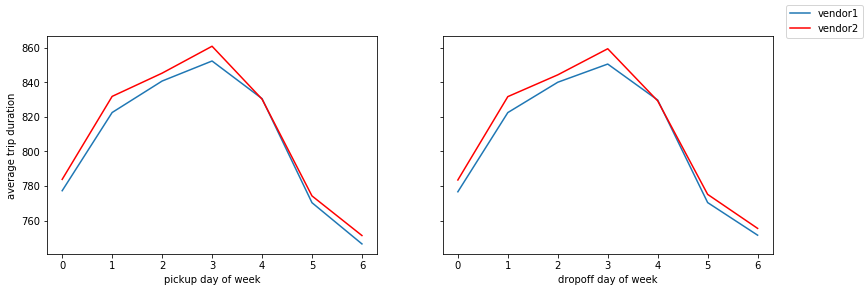

In [16]:
# On va regarder si les informations de dates sont importantes
tripDurationByVendorID_pickupDayOfWeek = dfWithoutPCount.groupby(['vendor_id', 'pickupDayOfWeek'])[['trip_duration']].mean()
tripDurationByVendorID_pickupDayOfWeek.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupDayOfWeek[tripDurationByVendorID_pickupDayOfWeek.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupDayOfWeek[tripDurationByVendorID_pickupDayOfWeek.vendor_id == 2]

tripDurationByVendorID_dropoffDayOfWeek = dfWithoutPCount.groupby(['vendor_id', 'dropoffDayOfWeek'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffDayOfWeek.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffDayOfWeek[tripDurationByVendorID_dropoffDayOfWeek.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffDayOfWeek[tripDurationByVendorID_dropoffDayOfWeek.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(13,4))
ax1.set(ylabel='average trip duration', xlabel='pickup day of week')
ax2.set(xlabel='dropoff day of week')

ax1.plot(pickupVendor1.pickupDayOfWeek,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupDayOfWeek,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffDayOfWeek,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffDayOfWeek,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


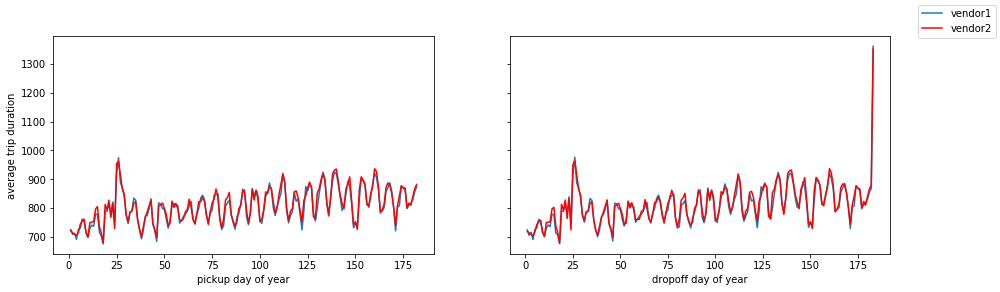

In [17]:
tripDurationByVendorID_pickupDayOfYear = dfWithoutPCount.groupby(['vendor_id', 'pickupDayOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_pickupDayOfYear.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupDayOfYear[tripDurationByVendorID_pickupDayOfYear.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupDayOfYear[tripDurationByVendorID_pickupDayOfYear.vendor_id == 2]

tripDurationByVendorID_dropoffDayOfYear = dfWithoutPCount.groupby(['vendor_id', 'dropoffDayOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffDayOfYear.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffDayOfYear[tripDurationByVendorID_dropoffDayOfYear.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffDayOfYear[tripDurationByVendorID_dropoffDayOfYear.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup day of year')
ax2.set(xlabel='dropoff day of year')

ax1.plot(pickupVendor1.pickupDayOfYear,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupDayOfYear,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffDayOfYear,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffDayOfYear,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


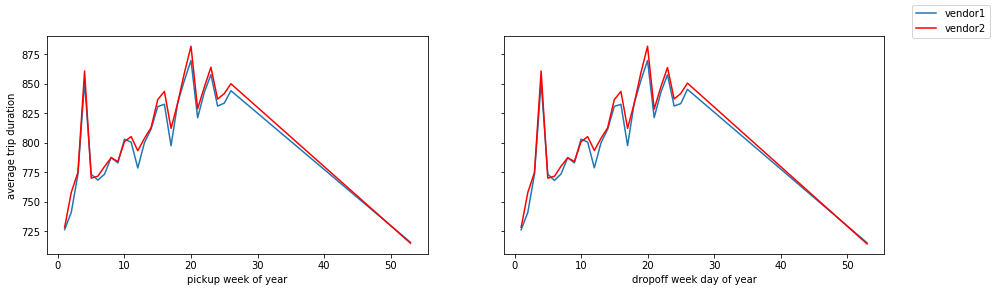

In [18]:
tripDurationByVendorID_pickupWeekOfYear = dfWithoutPCount.groupby(['vendor_id', 'pickupWeekOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_pickupWeekOfYear.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupWeekOfYear[tripDurationByVendorID_pickupWeekOfYear.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupWeekOfYear[tripDurationByVendorID_pickupWeekOfYear.vendor_id == 2]

tripDurationByVendorID_dropoffWeekOfYear = dfWithoutPCount.groupby(['vendor_id', 'dropoffWeekOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffWeekOfYear.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffWeekOfYear[tripDurationByVendorID_dropoffWeekOfYear.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffWeekOfYear[tripDurationByVendorID_dropoffWeekOfYear.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup week of year')
ax2.set(xlabel='dropoff week day of year')

ax1.plot(pickupVendor1.pickupWeekOfYear,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupWeekOfYear,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffWeekOfYear,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffWeekOfYear,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


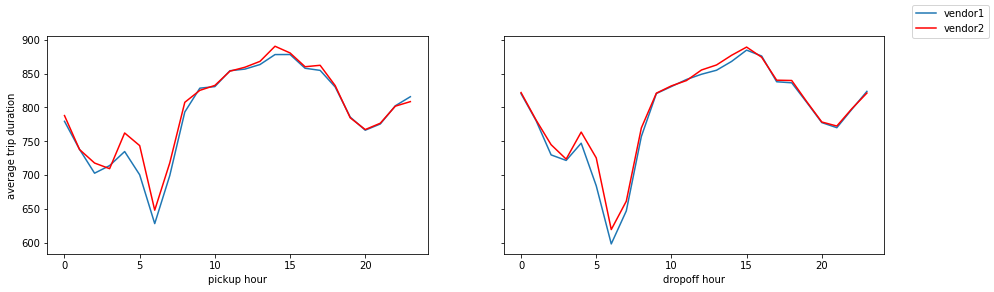

In [19]:
tripDurationByVendorID_pickupHour = dfWithoutPCount.groupby(['vendor_id', 'pickupHour'])[['trip_duration']].mean()
tripDurationByVendorID_pickupHour.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupHour[tripDurationByVendorID_pickupHour.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupHour[tripDurationByVendorID_pickupHour.vendor_id == 2]

tripDurationByVendorID_dropoffHour = dfWithoutPCount.groupby(['vendor_id', 'dropoffHour'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffHour.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffHour[tripDurationByVendorID_dropoffHour.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffHour[tripDurationByVendorID_dropoffHour.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup hour')
ax2.set(xlabel='dropoff hour')

ax1.plot(pickupVendor1.pickupHour,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupHour,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffHour,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffHour,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


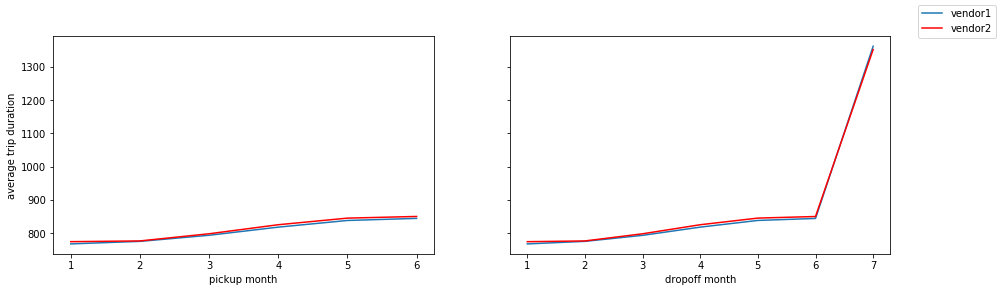

In [20]:
tripDurationByVendorID_pickupMonth = dfWithoutPCount.groupby(['vendor_id', 'pickupMonth'])[['trip_duration']].mean()
tripDurationByVendorID_pickupMonth.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupMonth[tripDurationByVendorID_pickupMonth.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupMonth[tripDurationByVendorID_pickupMonth.vendor_id == 2]

tripDurationByVendorID_dropoffMonth = dfWithoutPCount.groupby(['vendor_id', 'dropoffMonth'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffMonth.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffMonth[tripDurationByVendorID_dropoffMonth.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffMonth[tripDurationByVendorID_dropoffMonth.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup month')
ax2.set(xlabel='dropoff month')

ax1.plot(pickupVendor1.pickupMonth,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupMonth,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffMonth,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffMonth,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

In [21]:
# On voit avec ces graphiques que globalement le vendeur 2 met un peu plus de temps que le vendeur 1 mais surtout que la date de pickup ou de dropoff donne des courbes presques parfaitement similaires, on peut donc n'en garder qu'une des deux. On choisit de garder pickup. De plus, les carbes sont presques plate pour les mois, l'écart est de moins de 100, je ne suis pas sûr qu'il soit cohérent de les garder
dropCols = ['vendor_id','dropoffDayOfWeek','dropoffWeekOfYear','dropoffDayOfYear','dropoffHour','dropoffMonth']
dfWithoutUseless = dfWithoutPCount.drop(dropCols,axis=1)

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


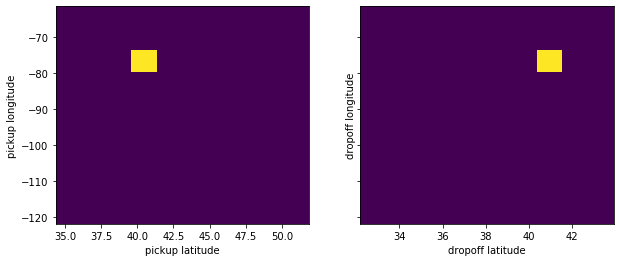

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),sharey=True)

ax1.set(xlabel='pickup latitude',ylabel='pickup longitude')
ax2.set(xlabel='dropoff latitude',ylabel='dropoff longitude')

ax1.hist2d(dfWithoutUseless.pickup_latitude,dfWithoutUseless.pickup_longitude,label='pickup coord')
ax2.hist2d(dfWithoutUseless.dropoff_latitude,dfWithoutUseless.dropoff_longitude,label='dropoff coord')
fig.show()

In [23]:
# On peut supprimer les lattitudes entre 40 et 42 et les longitudes entre -70 et -80
dfGood = dfWithoutUseless[(dfWithoutUseless.pickup_longitude >= -74.05) & (dfWithoutUseless.pickup_longitude <= -73.7) & (dfWithoutUseless.pickup_latitude >= 40.60) & (dfWithoutUseless.pickup_latitude <= 40.9) & (dfWithoutUseless.dropoff_longitude >= -74.05) & (dfWithoutUseless.dropoff_longitude <= -73.7) & (dfWithoutUseless.dropoff_latitude >= 40.60) & (df.dropoff_latitude <= 40.9)]
print(dfWithoutUseless.shape)
print(dfGood.shape)

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
(1420720, 10)
(1415740, 10)


/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


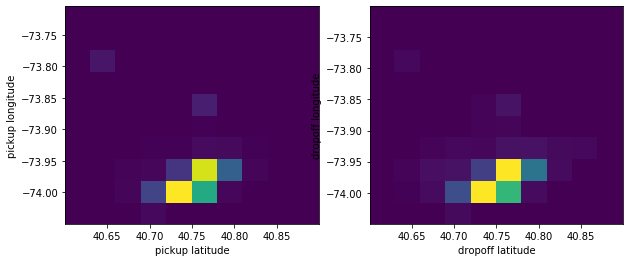

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.set(xlabel='pickup latitude',ylabel='pickup longitude')
ax2.set(xlabel='dropoff latitude',ylabel='dropoff longitude')

ax1.hist2d(dfGood.pickup_latitude,dfGood.pickup_longitude,label='pickup coord')
ax2.hist2d(dfGood.dropoff_latitude,dfGood.dropoff_longitude,label='dropoff coord')

fig.show()

In [25]:
# On a supprimer les locations trop éloignée, on va maintenant faire un cluqtering des pickups
kmeanPickup = KMeans(n_clusters=7,random_state=2,n_init=1).fit(dfGood[['pickup_longitude','pickup_latitude']])
kmeanDropoff = KMeans(n_clusters=7,random_state=2,n_init=1).fit(dfGood[['dropoff_longitude','dropoff_latitude']])

/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<BarContainer object of 7 artists>

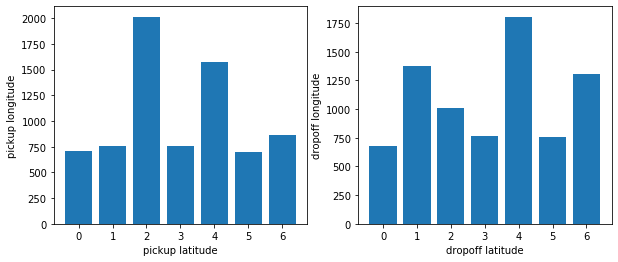

In [27]:
dfGood['clusterPickup'] = kmeanPickup.labels_
dfGood['clusterDropoff'] = kmeanDropoff.labels_

tripdurationByCluster = dfGood.groupby('clusterPickup')[['trip_duration']].mean()
tripdurationByCluster.reset_index(inplace=True)

tripdurationByCluster_ = dfGood.groupby('clusterDropoff')[['trip_duration']].mean()
tripdurationByCluster_.reset_index(inplace=True)

#plt.bar(tripdurationByCluster.clusterPickup.values, tripdurationByCluster.trip_duration.values)
#plt.xlabel('cluster pickup')
#plt.ylabel('trip duration (s)')
#plt.show()
#
#plt.bar(tripdurationByCluster_.clusterDropoff.values, tripdurationByCluster_.trip_duration.values)
#plt.xlabel('cluster dropoff')
#plt.ylabel('trip duration (s)')
#plt.show()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.set(xlabel='pickup latitude',ylabel='pickup longitude')
ax2.set(xlabel='dropoff latitude',ylabel='dropoff longitude')

ax1.bar(tripdurationByCluster.clusterPickup.values, tripdurationByCluster.trip_duration.values)
ax2.bar(tripdurationByCluster_.clusterDropoff.values, tripdurationByCluster_.trip_duration.values)

In [28]:
# Maintenant que l'on a des données exploitable, on va pouvoir commencer l'entraînement (et croiser les doigts pour que ça marche mieux [edit] Oh que oui ça a mieu marché *_*)
X = dfGood.loc[:,dfGood.columns != 'trip_duration']
Y = dfGood.trip_duration
XTrain, XTest, YTrain, YTest = train_test_split(X,Y,train_size=0.8,random_state=19061996)

In [30]:
def RSMLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true,y_pred))

def printTrainingInfo(timeFit,timePred,YPreds,YTrue=YTest):
    errorInSeconds = mean_absolute_error(YTrue,YPreds)
    
    error = RSMLE(YTrue,YPreds)

    endMsg = " t={:.2f}s (f={:.2f}s p={:.2f}s) e={:.5f} (={:.2f}s)\n".format(timeFit + timePred,timeFit,timePred,error,errorInSeconds)
    print(endMsg,end='')

def trainModelAndDisplayTrainingInfo(model,xTrain=XTrain,xTest=XTest,yTrain=YTrain):
    startFit = time.time()
    model.fit(xTrain,yTrain)
    endFit = time.time()

    startPred = time.time()
    preds = model.predict(xTest)
    endPred = time.time()

    printTrainingInfo(endFit-startFit,endPred-startPred,preds,YTest)

In [31]:
### TRAINING WITH RANDOM FOREST REGRESSOR ###
def train (n, d,jobs=None):
    startingMsg = "Starting n={} d={} ".format(n,d)
    print(startingMsg,end='')
    
    model = RandomForestRegressor(random_state=19061996,n_estimators=n, max_depth=d,n_jobs=jobs)

    trainModelAndDisplayTrainingInfo(model)

N = [30]
D = [50]

# +---------> D
# |
#\|/
# N
mask = [[1]]
print("training with {} threads".format(os.cpu_count()))
#Je vérifie que je n'est pas fait de la merde
assert(len(mask) == len(N))
for i in range(len(N)):
    assert(len(mask[i]) == len(D))

for i in range(len(N)):
    for j in range (len(D)):
        if mask[i][j] == 1:
            train(N[i],D[j],os.cpu_count())
    print('')

training with 4 threads
Starting n=30 d=50 t=361.98s (f=351.06s p=10.92s) e=0.32468 (=171.23s)



In [43]:
### TRAINING WITH SVR ###
# Les résultats de SVR ne sont pas indépendants de la répartition des données (c'est dit dans la doc de sklearn), il faut donc remettre X entre [-1,1], [0,1] ou avec une moyenne de 0 et un écart type de 1. Je les remet entre [0,1] car la fonction qui permet de calculer le score avec Kaggle (RSMLE) ne marche pas avec les nombres négatifs. Est ce que je suis intelligent et ait trouvé ça tout seul ?... ... ... Suspens... ... ... eh bas non, moi j'avais centré et réduit mes données, du coup j'avais des nombres négatifs, Python m'a insulté et j'ai compris
copyItem = 3000

scaler = preprocessing.MinMaxScaler()
SVRXTrain = scaler.fit_transform(XTrain[:copyItem])
SVRYTrain = YTrain[:copyItem].copy()

#model = RandomForestRegressor(random_state=19061996,n_jobs=2)

#gridSearch = GridSearchCV(model,{'n_estimators':[10,20], 'max_depth':[10]},scoring=make_scorer(mean_squared_log_error,greater_is_better=False),error_score=0,verbose=12,n_jobs=2).fit(XTrain,YTrain)
gridSearch = GridSearchCV(SVR(),{'C':[1000,1500,2000],'epsilon':[1,.1,.01,.001],'gamma':[10,5,1,.1,.01,.001]},n_jobs=os.cpu_count(),error_score=0,verbose=10).fit(SVRXTrain,SVRYTrain)
#trainModelAndDisplayTrainingInfo(SVR(kernel='rbf',C=1500,cache_size=2048),SVRXTrain,scaler.fit_transform(XTest),SVRYTrain)
print(gridSearch.best_params_)
pd.DataFrame(gridSearch.cv_results_).set_index(['param_epsilon'])

12.3s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
param_epsilon,,,,,,,,,,,,,,,
1.000,2.229882,0.125697,0.129051,0.046677,1000,10,"{'C': 1000, 'epsilon': 1, 'gamma': 10}",0.420641,0.469293,0.453218,0.480504,0.406156,0.445962,0.028340,21
1.000,1.466226,0.149651,0.078653,0.008546,1000,5,"{'C': 1000, 'epsilon': 1, 'gamma': 5}",0.447387,0.505666,0.481559,0.506835,0.453131,0.478916,0.025143,9
1.000,0.789282,0.035128,0.081875,0.012207,1000,1,"{'C': 1000, 'epsilon': 1, 'gamma': 1}",0.394722,0.444072,0.421375,0.376042,0.379101,0.403062,0.026042,33
1.000,0.620513,0.030848,0.082649,0.015483,1000,0.1,"{'C': 1000, 'epsilon': 1, 'gamma': 0.1}",0.178592,0.193186,0.134862,0.094046,0.134774,0.147092,0.035305,48
1.000,0.564028,0.021786,0.078921,0.007376,1000,0.01,"{'C': 1000, 'epsilon': 1, 'gamma': 0.01}",0.103314,0.099730,0.065498,0.044722,0.069066,0.076466,0.022112,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.001,3.054078,0.372139,0.144682,0.066919,2000,5,"{'C': 2000, 'epsilon': 0.001, 'gamma': 5}",0.450948,0.527845,0.481297,0.526248,0.479579,0.493183,0.029681,4
0.001,1.123774,0.100684,0.179739,0.117929,2000,1,"{'C': 2000, 'epsilon': 0.001, 'gamma': 1}",0.426213,0.481058,0.461200,0.437568,0.419633,0.445134,0.022866,28
0.001,0.714000,0.114222,0.074865,0.005610,2000,0.1,"{'C': 2000, 'epsilon': 0.001, 'gamma': 0.1}",0.193314,0.212866,0.156051,0.113603,0.150596,0.165286,0.034703,40


In [44]:
printTrainingInfo(0,0,gridSearch.predict(XTest[:copyItem]),YTest[:copyItem])

t=0.00s (f=0.00s p=0.00s) e=1.06839 (=775.22s)


In [ ]:
### TRAINING WITH NEURAL NETWORK ###
copyItem = 10000
model = MLPRegressor()

scaler = preprocessing.MinMaxScaler()
MLPXTrain = scaler.fit_transform(XTrain[:copyItem])
MLPYTrain = YTrain[:copyItem].copy()